## Filtrado colaborativo


In [183]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# citation: https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate as cv
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import cross_validate
import random

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [4]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(prediction, ground_truth)


In [5]:
#reviews = pd.read_csv('yelp_reviews_restaurantes.csv')
reviews = pd.read_csv('yelp_reviews_restaurantes_top20ciudadycategoria.csv')
print("Undersampling of the dataset started--------")
print(reviews.count())
#Undersampling of the dataset to get a balanced dataset
review1 = reviews[reviews['stars'] == 1][0:7000]
#print(review1.count())
review2 = reviews[reviews['stars'] == 2][0:7000]
#print(review2.count())
review3 = reviews[reviews['stars'] == 3][0:7000]
#print(review3.count())
review4 = reviews[reviews['stars'] == 4][0:7000]
#print(review4.count())
review5 = reviews[reviews['stars'] == 5][0:7000]
#print(review5.count())

frames = [review1, review2, review3,review4,review5]
reviews = pd.concat(frames)


Undersampling of the dataset started--------
business_id     86894
name            86894
address         85940
city            86894
state           86894
postal_code     86888
latitude        86894
longitude       86894
stars           86894
review_count    86894
is_open         86894
attributes      85741
categories      86894
hours           83657
user_id         86894
review_stars    86894
text            86894
date            86894
dtype: int64


In [8]:
reviews_all=reviews.sort_values(by='date')

In [9]:
reviews=reviews_all[['user_id','business_id','stars', 'date']].copy().sort_values(by='date')
reviews_all['user_id_simple'] = pd.factorize(reviews.user_id)[0]
reviews_all['business_id_simple'] = pd.factorize(reviews.business_id)[0]
reviews['user_id_simple'] = pd.factorize(reviews.user_id)[0]
reviews['business_id_simple'] = pd.factorize(reviews.business_id)[0]
reviews_all.tail(10)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date,user_id_simple,business_id_simple
84045,Y_UDKhe8scf8yui0NNvyJQ,Sushi Hana,1220 Pennsylvania Ave,Boulder,CO,80302.0,40.008530,-105.276677,3.0,40,1,"{'NoiseLevel': ""u'average'"", 'BusinessParking'...","Japanese, Restaurants, Sushi Bars","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",XC1WJ63A4QBPabalMBS_Rg,5,Literally the greatest restaurant of all time....,2021-01-26 20:47:21,13004,302
65380,DNhA9k9BJCmI6Jgq5h4aNg,Tad Smith Health Insurance,"4710 Table Mesa Dr, Ste A",Boulder,CO,80305.0,39.985104,-105.238990,5.0,11,1,"{'AcceptsInsurance': 'False', 'BusinessAccepts...","Financial Services, Life Insurance, Insurance,...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",-1OoW3W6-JQjZe94AcAgVA,5,"We had a wonderful experience with Tad, who he...",2021-01-26 21:58:12,13005,585
67348,WhrHFYy5WQy4-hLevjV0NQ,Rinnova Skin & Body,"2600 30th St, Ste 100",Boulder,CO,80301.0,40.027156,-105.253428,5.0,40,1,"{'BusinessParking': ""{'garage': False, 'street...","Skin Care, Medical Centers, Hair Removal, Medi...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",p1sdUUnqQnEYfOD0ygDxDw,5,Lily and Jessie at Rinnova are AMAZING! Broug...,2021-01-27 00:53:00,4154,395
53926,4mwAcjFUJHUSNfcRoovVmw,CakeKnife Photography,NaN,Boulder,CO,80304.0,40.045474,-105.283851,5.0,9,1,{'BusinessAcceptsCreditCards': 'True'},"Session Photography, Event Photography, Event ...","{'Monday': '8:0-19:0', 'Tuesday': '8:0-19:0', ...",csMzGqKi4PaJ1ymSgLrq4Q,5,Marla and her team are without a doubt phenome...,2021-01-27 02:54:55,13006,556
76285,UxM5xYEsUTHRnJosq2pE6Q,Nopalito's,"2850 Iris Ave, Ste H",Boulder,CO,80301.0,40.034961,-105.256565,5.0,66,1,"{'HasTV': 'True', 'BusinessAcceptsCreditCards'...","Restaurants, Mexican, Breakfast & Brunch, Nigh...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-20:0', '...",Op2Dvpc7cIe6VVBuBE0OMw,5,Probably the best value for Mex in Boulder. T...,2021-01-27 18:05:45,12088,629
70475,djkm7IvgkEakggJ0QbsECQ,Millennium Harvest House Boulder,1345 28th St,Boulder,CO,80302.0,40.012802,-105.260062,2.0,319,1,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Hotels & Travel, Hotels, Event Planning & Serv...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",ae3iEJueszkZPIyKeBC8WQ,1,STAY AWAY! My better judgment escaped me when ...,2021-01-27 19:33:07,13007,13
60099,j3seP7YkE7nFOT6fvKT8EQ,Precision Carpet Cleaning & Janitorial,"4919 Broadway St, Ste 8",Boulder,CO,80304.0,40.063908,-105.282715,5.0,10,1,{'BusinessAcceptsCreditCards': 'True'},"Contractors, Office Cleaning, Damage Restorati...","{'Monday': '8:30-17:0', 'Tuesday': '8:30-17:0'...",7Veu9MBr-2me7XcYy2Eepg,5,Could not be happier with the service I receiv...,2021-01-27 22:46:58,13008,119
72053,oXSbVk-cvjtYiDvBGnUUIQ,Sundown Saloon,1136 Pearl St Bsmt,Boulder,CO,80302.0,40.017559,-105.280330,3.0,125,1,"{'NoiseLevel': ""u'very_loud'"", 'BusinessAccept...","Bars, Nightlife, Dive Bars","{'Monday': '15:0-2:0', 'Tuesday': '15:0-2:0', ...",_Iqm0xLmFZQeRKzaBHFfHg,5,What happens when you are lost and try to take...,2021-01-28 02:08:39,13009,10
85854,pU5YFxKO6DAw95I5uKQ7Hg,Brian Sundberg Real Estate - RE/MAX,"2425 Canyon Blvd, Ste 110",Boulder,CO,80302.0,40.018006,-105.262727,5.0,19,1,{'BusinessAcceptsCreditCards': 'False'},"Home Services, Real Estate Services, Real Esta...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",mqoIYY44SyPV5veWL_f_uA,5,Brian was very knowledgeable and a great resou...,2021-01-28 03:05:33,13010,534
62321,qjFpQwHuAA6hpnou0D3m7g,Closetbox Storage,1105 Spruce Street,Boulder,CO,80302.0,40.018907,-105.281500,3.0,54,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Home Services, Self Storage, Local Services, M...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",1_r6tU_1bk-wdXdYlNoHfw,1,Would not recommend it for military people bec...,2021-01-28 14:16:56,13011,405


In [189]:
reviews.shape

reviews

,user_id,business_id,stars,date,user_id_simple,business_id_simple
22656,xlgyc1W1wRquXpUDdll7eg,G_TKJboaInOx7KjAUWw0Fg,3.0,2005-07-29 05:33:02,0,0
5716,y6-ONuzNIxAfsgfeT53_sA,jBVrYylU6MWUWFVbcTa7OA,4.0,2005-12-10 20:19:17,1,1
76037,nwGGfFMyycQImACGSQke6A,PqhXv0Y-wGeIx014VVLYiw,3.0,2006-01-05 04:52:40,2,2
22690,3CBVeDLJJGfgdUDflpTrmA,G_TKJboaInOx7KjAUWw0Fg,3.0,2006-01-09 22:45:16,3,0
4591,3CBVeDLJJGfgdUDflpTrmA,cO7jsGW9ma4GBNekBnWThA,4.0,2006-01-12 23:04:45,3,3
...,...,...,...,...,...,...
70475,ae3iEJueszkZPIyKeBC8WQ,djkm7IvgkEakggJ0QbsECQ,2.0,2021-01-27 19:33:07,13007,13
60099,7Veu9MBr-2me7XcYy2Eepg,j3seP7YkE7nFOT6fvKT8EQ,5.0,2021-01-27 22:46:58,13008,119
72053,_Iqm0xLmFZQeRKzaBHFfHg,oXSbVk-cvjtYiDvBGnUUIQ,3.0,2021-01-28 02:08:39,13009,10
85854,mqoIYY44SyPV5veWL_f_uA,pU5YFxKO6DAw95I5uKQ7Hg,5.0,2021-01-28 03:05:33,13010,534


In [190]:
test_size=int(.2*reviews.shape[0])
test_size
train_size= int(reviews.shape[0]-test_size)
train_size

14328

In [10]:
print("Undersampling of the dataset completed--------")
# converting user_id and business_id to integers for the matrix

# getting the number unique users and restaurants
unique_users = reviews.user_id.unique().shape[0]
unique_restaurants = reviews.business_id.unique().shape[0]

reader = Reader( rating_scale = ( 0, 5 ) )
reviews.head()

Undersampling of the dataset completed--------


,user_id,business_id,stars,date,user_id_simple,business_id_simple
22656,xlgyc1W1wRquXpUDdll7eg,G_TKJboaInOx7KjAUWw0Fg,3.0,2005-07-29 05:33:02,0,0
5716,y6-ONuzNIxAfsgfeT53_sA,jBVrYylU6MWUWFVbcTa7OA,4.0,2005-12-10 20:19:17,1,1
76037,nwGGfFMyycQImACGSQke6A,PqhXv0Y-wGeIx014VVLYiw,3.0,2006-01-05 04:52:40,2,2
22690,3CBVeDLJJGfgdUDflpTrmA,G_TKJboaInOx7KjAUWw0Fg,3.0,2006-01-09 22:45:16,3,0
4591,3CBVeDLJJGfgdUDflpTrmA,cO7jsGW9ma4GBNekBnWThA,4.0,2006-01-12 23:04:45,3,3


In [11]:
unique_users

13012

In [12]:
unique_restaurants

650

In [192]:

#splitting the dataset
surprise_dataset = Dataset.load_from_df( reviews[ ["user_id_simple","business_id_simple","stars"] ], reader )
train_set, test_set=  train_test_split(surprise_dataset, test_size=.3)

sim_options = {'name': 'cosine',
               'user_based': True  # calcule similitud item-item
               }
for i in (3,6,9,12):
    algo1 = KNNBasic(k=i, min_k=1, sim_options=sim_options)
    predictions = algo1.fit(train_set).test(test_set)
    print(accuracy.rmse(predictions))
#predictions

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8856
0.8855688114321296
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8856
0.8855688114321296
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8856
0.8855688114321296
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8856
0.8855688114321296


In [193]:
predictions[0]

Prediction(uid=3334, iid=187, r_ui=3.0, est=3.0, details={'actual_k': 4, 'was_impossible': False})

In [194]:
matching =[]
for prediction in predictions:
    #print(prediction.details['was_impossible'])
    if prediction.details['was_impossible']== False:
        matching.append(prediction)
#matching

In [195]:
# define a cross-validation iterator
from surprise.model_selection import KFold
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
kf = KFold(n_splits=10)

algo2 = SVD()

for trainset, testset in kf.split(surprise_dataset):

    # train and test algorithm.
    algo2.fit(trainset)
    predictions = algo2.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.3373
RMSE: 0.3091
RMSE: 0.3430
RMSE: 0.3192
RMSE: 0.3364
RMSE: 0.3287
RMSE: 0.3297
RMSE: 0.3388
RMSE: 0.3180
RMSE: 0.3383


In [196]:
#predictions

In [197]:
#Se convierte a dataframe
labels = ['user_id_simple','business_id_simple' ,'stars']
d1 = pd.DataFrame.from_records(list(map(lambda x: (x.uid,x.iid, x.est) , matching)), columns=labels)
d2 = pd.DataFrame.from_records(list(map(lambda x: (x.uid,x.iid, x.est) , predictions)), columns=labels)
res = pd.merge(d1, d2,how='inner', on=['user_id_simple', 'business_id_simple'])
reviews_res= pd.merge(res, reviews_all,how='inner', on=['user_id_simple', 'business_id_simple'])
reviews_res.head(2)

,user_id_simple,business_id_simple,stars_x,stars_y,business_id,name,address,city,state,postal_code,...,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date
0,96,83,3.0,3.198237,qvHOOtGy1MHm5DrCaBr44w,Urban Outfitters,934 Pearl St,Boulder,CO,80302.0,...,3.0,15,1,"{'BusinessParking': ""{'garage': False, 'street...","Women's Clothing, Shopping, Home & Garden, Sho...","{'Monday': '11:0-19:0', 'Tuesday': '11:0-18:0'...",2Z0I9POv2N5p1_vOnCN9lw,4,What? The first review of U.O. Boulder is by a...,2008-10-13 14:28:12
1,6756,182,3.0,3.058600,jLA3i4sZUxARyAFZylis6A,Goodwill Boulder,2486 Baseline Rd,Boulder,CO,80305.0,...,3.0,36,1,"{'BusinessParking': ""{'garage': False, 'street...","Thrift Stores, Shopping","{'Monday': '0:0-0:0', 'Tuesday': '9:0-20:0', '...",AX6_NL1_GTM2tcN9jn8mQw,1,A very disappointing experience at this Goodwi...,2017-12-18 02:44:15


<AxesSubplot:ylabel='Frequency'>

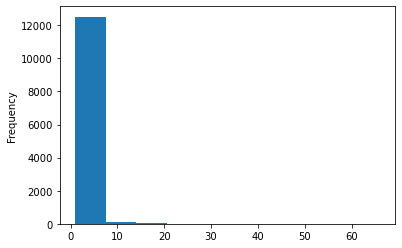

In [69]:
reviews['user_id'].value_counts(ascending=False).plot.hist()

In [143]:
reviews

,user_id,business_id,stars,date
19840,0,0,3.0,2005-07-29 05:33:02
7316,1,1,3.0,2006-01-06 03:16:27
19874,1,0,3.0,2006-01-09 22:45:16
13669,2,2,3.0,2006-01-15 17:16:33
4379,3,3,3.0,2006-01-16 03:43:13
...,...,...,...,...
30096,9515,192,3.0,2021-01-26 16:18:21
71326,9516,137,3.0,2021-01-26 20:47:21
65259,9038,189,5.0,2021-01-27 18:05:45
60757,9517,19,2.0,2021-01-27 19:33:07


<AxesSubplot:ylabel='Frequency'>

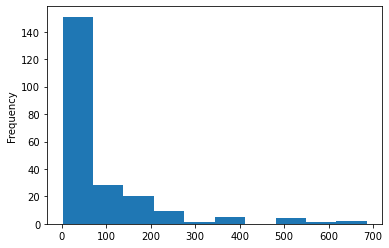

In [70]:
reviews['business_id'].value_counts(ascending=False).plot.hist()

<AxesSubplot:ylabel='Frequency'>

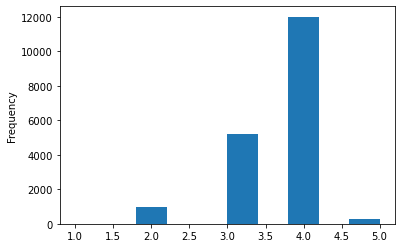

In [71]:
reviews.stars.plot.hist()

## Insertar a BD

In [255]:
!pip install mysql
!pip install mysql.connector
!pip install mysql-connector-python-rf
import mysql.connector
from mysql.connector import errorcode
#Configuración de la conexión a Mysql
try:
  cnx = mysql.connector.connect(user='user_taller2', password='taller2.', host='127.0.0.1', database='taller2')
except mysql.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)

cursor = cnx.cursor()

In [212]:
reviews_res.describe()

,user_id_simple,business_id_simple,stars_x,stars_y,postal_code,latitude,longitude,stars,review_count,is_open,review_stars
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.0,224.000000
mean,4497.754464,195.013393,3.611607,3.610040,80302.343750,40.017142,-105.265737,3.611607,195.116071,1.0,3.638393
std,3791.631047,191.578327,0.860727,0.702090,1.267976,0.019123,0.025167,0.860727,202.764094,0.0,1.469739
min,6.000000,0.000000,1.000000,1.408486,80301.000000,39.976051,-105.371668,1.000000,5.000000,1.0,1.000000
25%,1330.500000,44.000000,3.000000,3.071080,80302.000000,40.013584,-105.282153,3.000000,34.500000,1.0,3.000000
50%,3286.000000,110.500000,4.000000,3.932901,80302.000000,40.017311,-105.262466,4.000000,124.000000,1.0,4.000000
75%,8199.250000,324.000000,4.000000,3.997142,80303.000000,40.019503,-105.254604,4.000000,330.000000,1.0,5.000000
max,12772.000000,631.000000,5.000000,4.928035,80305.000000,40.073325,-105.200376,5.000000,628.000000,1.0,5.000000


In [218]:
sql = "INSERT INTO `recomendations_business` (`user_id`, `business_id`, `recomendation_score`) VALUES (%s, %s, %s)"


for i in reviews_res.index: 
    if reviews_res['stars_y'][i] >0 and reviews_res['stars_x'][i] > 0:
        #print(int(reviews_res['stars_y'][i]))
        #print(reviews_res['business_id'][i])
        cursor.execute(sql, (reviews_res['user_id'][i],reviews_res['business_id'][i],int(reviews_res['stars_y'][i])))
        cnx.commit()

In [227]:
# getting the number unique users and restaurants
unique_users = reviews_all.user_id.unique().shape[0]
unique_restaurants = reviews_all.business_id.unique().shape[0]
current_reviews= reviews_all[ ["user_id_simple","business_id_simple","stars"] ]
#Create two user-item matrices, one for training and another for testing
matrix_all = np.zeros((unique_users, unique_restaurants))

for line in current_reviews.itertuples():
    #print(line[1])
    matrix_all[line[1], line[2]] = line[3]
matrix_all

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 4., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [245]:
reviews_all.loc[reviews_all.business_id_simple==1].business_id.unique()[0]

'jBVrYylU6MWUWFVbcTa7OA'

In [ ]:
for i in range(0,unique_users):
    user_id = reviews_all.loc[reviews_all.user_id_simple==i].user_id.unique()[0]
    for j in range(0, unique_restaurants):
        if matrix_all[i][j] == 0:    
            star2=algo1.predict(i, j, r_ui=None, verbose=True)
            #print(star2.est)
            star1=algo2.predict(i, j, r_ui=None, verbose=True)
            #print(star1.est)
            #print(star.est)
            if int(star1.est) == int(star2.est):
                business_id =reviews_all.loc[reviews_all.business_id_simple==j].business_id.unique()[0]
                #print(user_id, business_id)
                print("iguallll")
                cursor.execute(sql, (user_id,business_id,int(star1.est)))
                cnx.commit()

user: 1536       item: 621        r_ui = None   est = 3.71   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 1541       item: 24         r_ui = None   est = 3.71   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 1541       item: 24         r_ui = None   est = 4.97   {'was_impossible': False}
user: 1541       item: 25         r_ui = None   est = 3.71   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 1541       item: 25         r_ui = None   est = 3.84   {'was_impossible': False}


In [ ]:
cursor.close()
cnx.close()